In [30]:
import networkx as nx
import pandas as pd
import os
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import time
import random
from sklearn.metrics import f1_score
from collections import defaultdict 
from dgl.nn import SAGEConv
import scipy.sparse as sp
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import dgl
from dgl.data.utils import save_graphs
from dgl import load_graphs

In [3]:
from dgl.nn import SAGEConv
import dgl.data

In [4]:
#%autosave 0

Autosave disabled


# Feature PreProcessing

In [5]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [5]:
features = pd.read_csv('~/teams/DSC180A_FA21_A00/a13group1/songset_features_170k')

In [6]:
features = features.drop(columns=['Unnamed: 0', 'type', 'id', 'uri', 'track_href', 'analysis_url'])

In [7]:
std_scaler = StandardScaler()
features['loudness'] = std_scaler.fit_transform(features[['loudness']])
features['tempo'] = std_scaler.fit_transform(features[['tempo']])

In [8]:
one_hot = OneHotEncoder()

key_names = [f'key{i}' for i in range(12)]
one_hot_key = pd.DataFrame(one_hot.fit_transform(features[['key']]).toarray())
one_hot_key.columns = key_names

ts_names = [f'ts{i}' for i in range(5)]
one_hot_ts = pd.DataFrame(one_hot.fit_transform(features[['time_signature']]).toarray())
one_hot_ts.columns = ts_names

In [9]:
features = pd.concat([features, one_hot_key, one_hot_ts], axis=1)
features = features.drop(columns=['key', 'time_signature'])

In [10]:
features

danceability  energy  loudness  mode  speechiness  acousticness  \
0              0.904   0.813  0.241283     0       0.1210      0.031100   
1              0.774   0.838  0.932608     0       0.1140      0.024900   
2              0.664   0.758  0.354373     0       0.2100      0.002380   
3              0.892   0.714  0.468764     0       0.1410      0.201000   
4              0.853   0.606  0.784854     1       0.0713      0.056100   
...              ...     ...       ...   ...          ...           ...   
170084         0.551   0.822  0.260131     0       0.0614      0.001540   
170085         0.480   0.761  0.777921     1       0.0367      0.120000   
170086         0.402   0.767  0.325126     0       0.1710      0.000077   
170087         0.678   0.826  0.753223     0       0.0591      0.005240   
170088         0.670   0.483  0.237166     0       0.1250      0.213000   

        instrumentalness  liveness  valence     tempo  ...  key7  key8  key9  \
0               0.006970    0.0471    0.810  0.147007  ...   0.0   0.0   0.0   
1               0.025000    0.2420    0.924  0.745093  ...   0.0   0.0   0.0   
2               0.000000    0.0598    0.701 -0.744457  ...   0.0   0.0   0.0   
3               0.000234    0.0521    0.817 -0.686176  ...   0.0   0.0   0.0   
4               0.000000    0.3130    0.654 -0.897559  ...   0.0   0.0   0.0   
...                  ...       ...      ...       ...  ...   ...   ...   ...   
170084          0.000000    0.2150    0.360  0.200831  ...   0.0   0.0   0.0   
170085          0.000000    0.2960    0.359  1.322800  ...   0.0   0.0   0.0   
170086          0.000003    0.3930    0.558  1.944497  ...   0.0   0.0   0.0   
170087          0.000000    0.0951    0.706  0.641290  ...   0.0   0.0   0.0   
170088          0.000000    0.0550    0.770  1.666259  ...   0.0   0.0   1.0   

        key10  key11  ts0  ts1  ts2  ts3  ts4  
0         0.0    0.0  0.0  0.0  0.0  1.0  0.0  
1         0.0    0.0  0.0  0.0  0.0  1.0  0.0  
2         0.0    0.0  0.0  0.0  0.0  1.0  0.0  
3         0.0    0.0  0.0  0.0  0.0  1.0  0.0  
4         0.0    0.0  0.0  0.0  0.0  1.0  0.0  
...       ...    ...  ...  ...  ...  ...  ...  
170084    0.0    1.0  0.0  0.0  0.0  1.0  0.0  
170085    0.0    0.0  0.0  0.0  0.0  1.0  0.0  
170086    0.0    1.0  0.0  0.0  0.0  1.0  0.0  
170087    0.0    0.0  0.0  0.0  0.0  1.0  0.0  
170088    0.0    0.0  0.0  0.0  0.0  1.0  0.0  

[170089 rows x 28 columns]

In [11]:
features_arr = torch.tensor(np.array(features))

In [ ]:
torch.tensor((features['danceability']))

# EDA

In [13]:
numerical = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',]
categorical = ['key', 'mode', 'time_signature']

In [14]:
# "data/", "Spotify Playlist", 140, 300, 1000, False

In [15]:
# n = 10000
# count = 0
# print('Loading {} playlists'.format(n))
# for i in range(999, n, 1000):
#     with open("data/" + 'mpd.slice.{}-{}.json'.format(i - 999, i)) as f:
#         data = json.load(f)
#         playlists = data['playlists']

In [27]:
with open("" + 'mpd.slice.{}-{}.json'.format(0, 999)) as f:
        data = json.load(f)
        playlists = data['playlists']

In [73]:
edafeats = pd.read_csv('~/teams/DSC180A_FA21_A00/a13group1/songset_features_170k')
edafeats = edafeats.drop(columns=['Unnamed: 0', 'type', 'track_href', 'analysis_url'])

edafeats['loudness'] = std_scaler.fit_transform(edafeats[['loudness']])
edafeats['tempo'] = std_scaler.fit_transform(edafeats[['tempo']])
edafeats['duration_ms'] = std_scaler.fit_transform(edafeats[['duration_ms']])

In [74]:
%%time
feat_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_avgs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

for each in np.random.choice(999, 200):
    item = playlists[each]
    row_ids = []
    for i in item['tracks']:
        row = edafeats[edafeats['uri'] == i['track_uri']].index.item()
        row_ids.append(row)

    cur_feats = edafeats.iloc[row_ids]

    for i in numerical:
        var = np.var(cur_feats[i])
        feat_vars[i].append(var)
        
        avg = np.mean(cur_feats[i])
        feat_avgs[i].append(avg)
    for i in categorical:
        highest = max(cur_feats[i].value_counts() / cur_feats[i].count())
        feat_vars[i].append(highest)

CPU times: user 2min 39s, sys: 322 ms, total: 2min 40s
Wall time: 2min 40s


In [75]:
feat_avgs.pop('key')
feat_avgs.pop('mode')
feat_avgs.pop('time_signature')

[]

In [76]:
for i in list(feat_vars.keys()):
    print(i, np.mean(feat_vars[i]))

danceability 0.017336247228631585
energy 0.027802018795663744
loudness 0.35974512463583996
speechiness 0.006335275255969176
acousticness 0.04961921645380942
instrumentalness 0.020206595814568802
liveness 0.019993579739552073
valence 0.04086572118192583
tempo 0.8958084474863978
duration_ms 0.3048734709345499
key 0.193673401827415
mode 0.7014418832578955
time_signature 0.9303994774551134


In [77]:
for i in list(feat_avgs.keys()):
    print(i, len(feat_avgs[i]))

danceability 200
energy 200
loudness 200
speechiness 200
acousticness 200
instrumentalness 200
liveness 200
valence 200
tempo 200
duration_ms 200


# Within Playlists EDA (From 200 Song Sample)

When plotting the distribution of variance for danceability of the 200 sampled playlists we can see that it follows a sort of bimodal distribution, where the variance is always quite low. This suggests that the songs within each playlist follow a sort of similarity in danceability. As we plot the variances of the other playlists we can get different values.

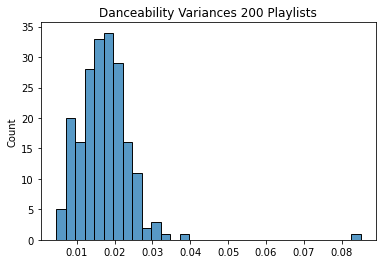

In [81]:
danceability_variances = sns.histplot(feat_vars['danceability']).set(title='Danceability Variances 200 Playlists')

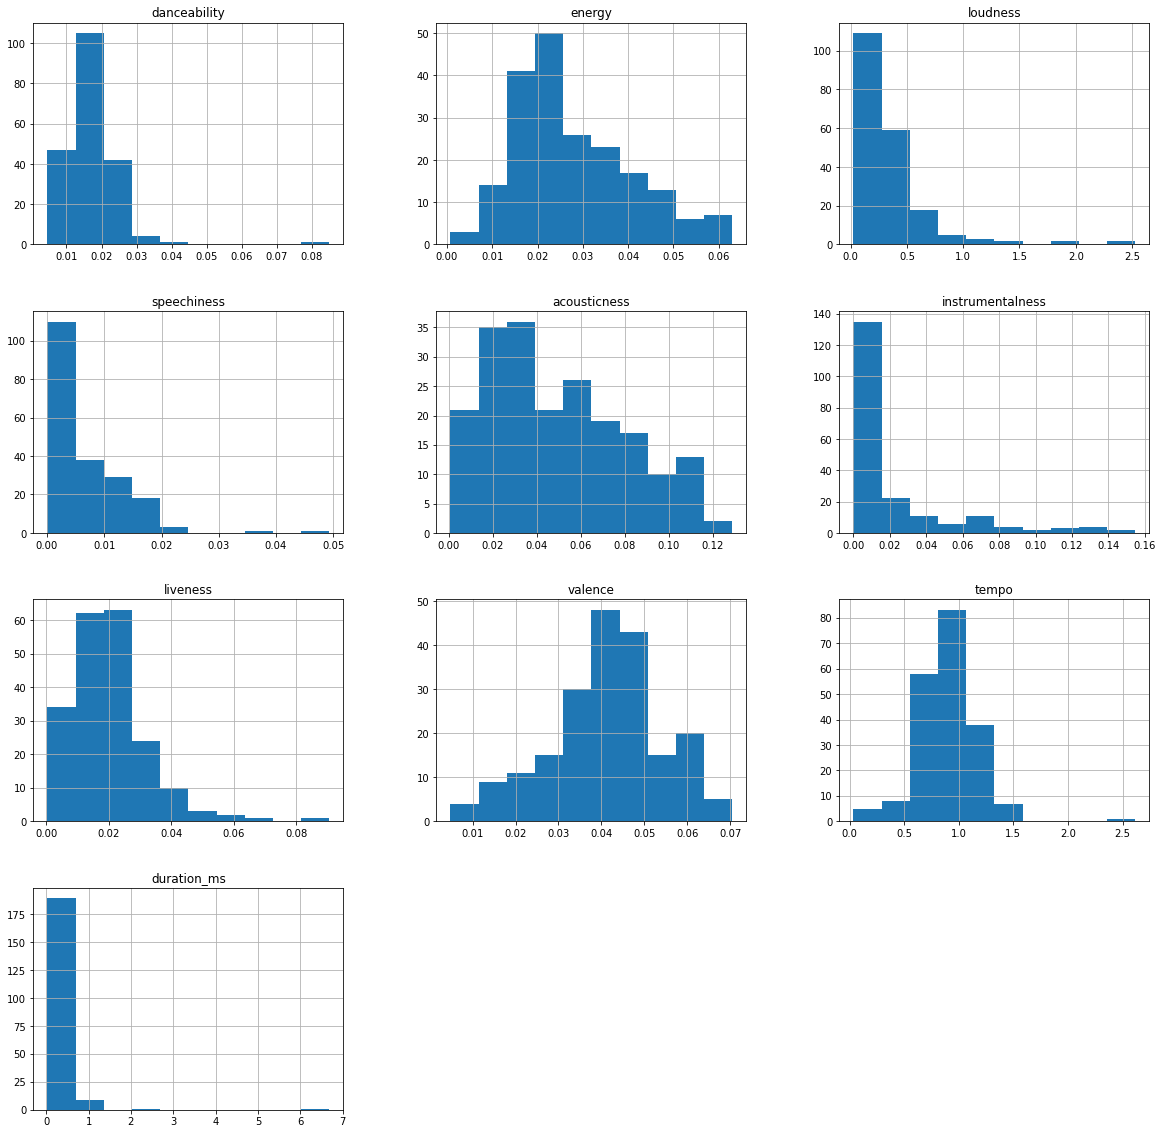

In [78]:
var_hists = pd.DataFrame(feat_vars)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

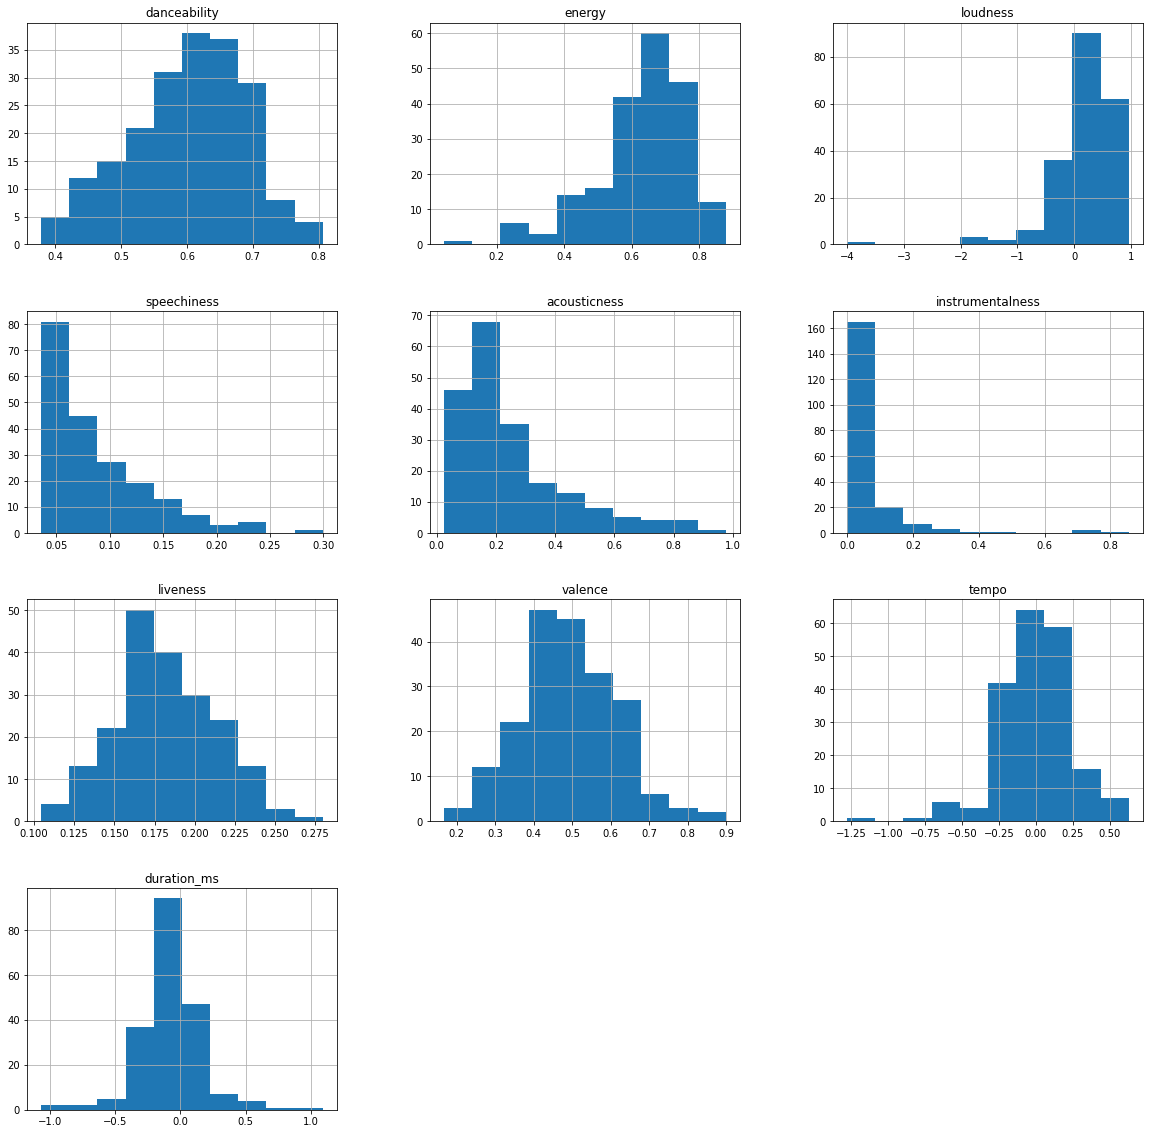

In [79]:
avg_hists = pd.DataFrame(feat_avgs)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

# Overall Songs EDA

<AxesSubplot:ylabel='time_signature'>

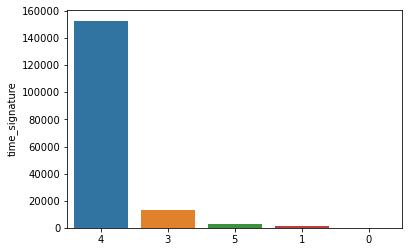

In [46]:
sns.barplot(y=edafeats['time_signature'].value_counts(), x=[str(i) for i in edafeats['time_signature'].value_counts().index])

<AxesSubplot:ylabel='key'>

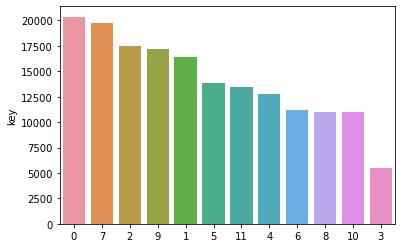

In [45]:
sns.barplot(y=edafeats['key'].value_counts(), x=[str(i) for i in edafeats['key'].value_counts().index])

<AxesSubplot:ylabel='mode'>

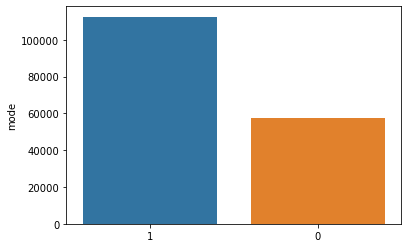

In [76]:
sns.barplot(y=edafeats['mode'].value_counts(), x=[str(i) for i in edafeats['mode'].value_counts().index])

<AxesSubplot:xlabel='energy', ylabel='Count'>

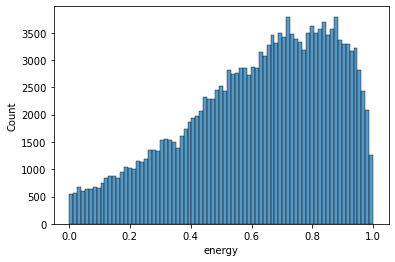

In [29]:
sns.histplot(edafeats['energy'])

<AxesSubplot:xlabel='danceability', ylabel='Count'>

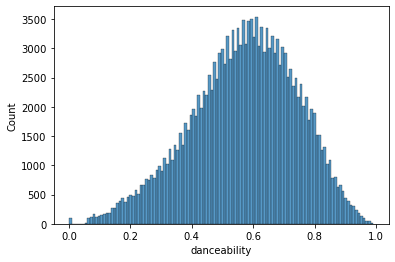

In [73]:
sns.histplot(edafeats['danceability'])

<AxesSubplot:xlabel='loudness', ylabel='Count'>

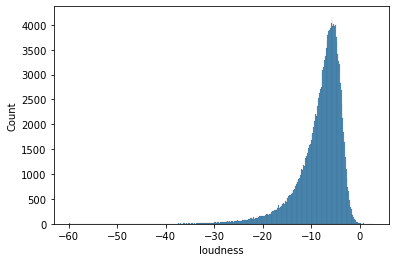

In [75]:
sns.histplot(edafeats['loudness'])

<AxesSubplot:xlabel='speechiness', ylabel='Count'>

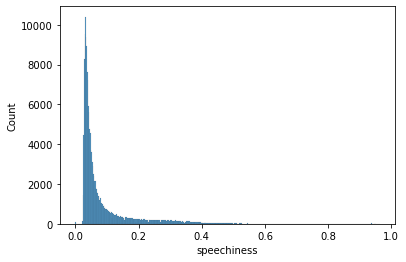

In [77]:
sns.histplot(edafeats['speechiness'])

<AxesSubplot:xlabel='acousticness', ylabel='Count'>

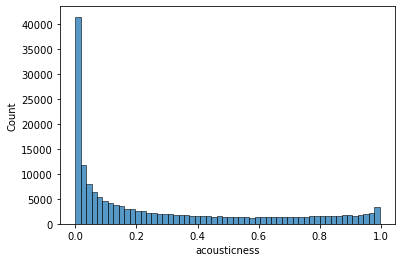

In [78]:
sns.histplot(edafeats['acousticness'])

<AxesSubplot:xlabel='instrumentalness', ylabel='Count'>

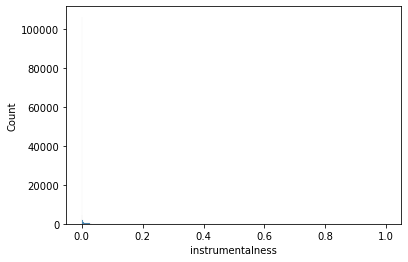

In [80]:
sns.histplot(features['instrumentalness'])

<AxesSubplot:xlabel='liveness', ylabel='Count'>

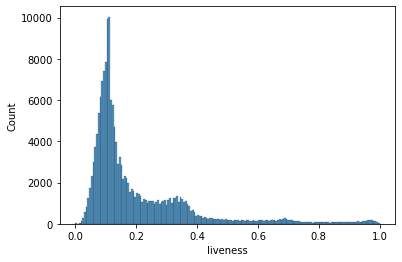

In [82]:
sns.histplot(edafeats['liveness'])

<AxesSubplot:xlabel='valence', ylabel='Count'>

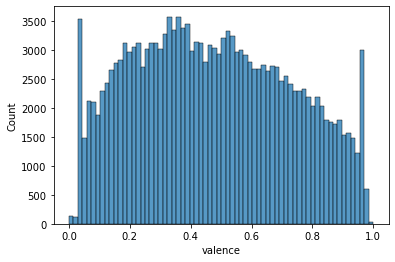

In [84]:
sns.histplot(edafeats['valence'])

<AxesSubplot:xlabel='tempo', ylabel='Count'>

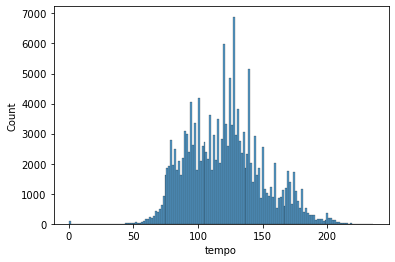

In [83]:
sns.histplot(edafeats['tempo'])

<AxesSubplot:xlabel='duration_ms', ylabel='Count'>

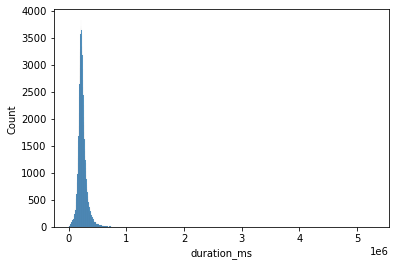

In [85]:
sns.histplot(edafeats['duration_ms'])

# Loads Graph

In [14]:
#%%time
#G = bf.load_data("data/", "Spotify Playlist", 140, 300, 1000, False)

In [15]:
%%time
dglG = load_graphs('./test_save.bin')[0][0]

CPU times: user 0 ns, sys: 948 ms, total: 948 ms
Wall time: 1.05 s


In [16]:
dglG

Graph(num_nodes=170089, num_edges=53216794,
      ndata_schemes={}
      edata_schemes={})

In [17]:
for i in features.columns:
    dglG.ndata[i] = torch.tensor(features[i])

In [18]:
dglG

Graph(num_nodes=170089, num_edges=53216794,
      ndata_schemes={'danceability': Scheme(shape=(), dtype=torch.float64), 'energy': Scheme(shape=(), dtype=torch.float64), 'loudness': Scheme(shape=(), dtype=torch.float64), 'mode': Scheme(shape=(), dtype=torch.int64), 'speechiness': Scheme(shape=(), dtype=torch.float64), 'acousticness': Scheme(shape=(), dtype=torch.float64), 'instrumentalness': Scheme(shape=(), dtype=torch.float64), 'liveness': Scheme(shape=(), dtype=torch.float64), 'valence': Scheme(shape=(), dtype=torch.float64), 'tempo': Scheme(shape=(), dtype=torch.float64), 'duration_ms': Scheme(shape=(), dtype=torch.int64), 'key0': Scheme(shape=(), dtype=torch.float64), 'key1': Scheme(shape=(), dtype=torch.float64), 'key2': Scheme(shape=(), dtype=torch.float64), 'key3': Scheme(shape=(), dtype=torch.float64), 'key4': Scheme(shape=(), dtype=torch.float64), 'key5': Scheme(shape=(), dtype=torch.float64), 'key6': Scheme(shape=(), dtype=torch.float64), 'key7': Scheme(shape=(), dtype=torch.

# Edge Splitting

In [19]:
# Split edge set for training and testing
u, v = dglG.edges()

In [20]:
eids = np.arange(dglG.number_of_edges())


In [21]:
eids = np.random.permutation(eids)


In [22]:
test_size = int(len(eids) * 0.1)


In [23]:
train_size = dglG.number_of_edges() - test_size


In [24]:
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]


In [25]:
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]


In [ ]:
# Find all negative edges and split them for training and testing


In [26]:
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))


In [27]:
#adj_neg = 1 - adj.todense() - np.eye(dglG.number_of_nodes())


In [28]:
#neg_u, neg_v = np.where(adj_neg != 0)


In [29]:
#neg_eids = np.random.choice(len(neg_u), dglG.number_of_edges() // 2)


In [30]:
#test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]


In [31]:
#train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [32]:
train_g = dgl.remove_edges(dglG, eids[:test_size])

In [33]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=dglG.number_of_nodes())
#train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=dglG.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=dglG.number_of_nodes())
#test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=dglG.number_of_nodes())

In [34]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [35]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]


In [36]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']


In [49]:
g.ndata['feat']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [47]:
model = GraphSAGE(features_arr.shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score):
    scores = ([pos_score])
    labels = (torch.ones(pos_score.shape[0]))
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score):
    scores = torch.cat([pos_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)


In [52]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, torch.tensor)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

RuntimeError: expected scalar type Double but found Float

In [4]:
pd.read_csv('songset_features_170k')

Unnamed: 0  danceability  energy  key  loudness  mode  speechiness  \
0                0         0.904   0.813    4    -7.105     0       0.1210   
1                1         0.774   0.838    5    -3.914     0       0.1140   
2                2         0.664   0.758    2    -6.583     0       0.2100   
3                3         0.892   0.714    4    -6.055     0       0.1410   
4                4         0.853   0.606    0    -4.596     1       0.0713   
...            ...           ...     ...  ...       ...   ...          ...   
170084      170084         0.551   0.822   11    -7.018     0       0.0614   
170085      170085         0.480   0.761    6    -4.628     1       0.0367   
170086      170086         0.402   0.767   11    -6.718     0       0.1710   
170087      170087         0.678   0.826    0    -4.742     0       0.0591   
170088      170088         0.670   0.483    9    -7.124     0       0.1250   

        acousticness  instrumentalness  liveness  valence    tempo  \
0           0.031100          0.006970    0.0471    0.810  125.461   
1           0.024900          0.025000    0.2420    0.924  143.040   
2           0.002380          0.000000    0.0598    0.701   99.259   
3           0.201000          0.000234    0.0521    0.817  100.972   
4           0.056100          0.000000    0.3130    0.654   94.759   
...              ...               ...       ...      ...      ...   
170084      0.001540          0.000000    0.2150    0.360  127.043   
170085      0.120000          0.000000    0.2960    0.359  160.020   
170086      0.000077          0.000003    0.3930    0.558  178.293   
170087      0.005240          0.000000    0.0951    0.706  139.989   
170088      0.213000          0.000000    0.0550    0.770  170.115   

                  type                      id  \
0       audio_features  0UaMYEvWZi0ZqiDOoHU3YI   
1       audio_features  6I9VzXrHxO9rA9A5euc8Ak   
2       audio_features  0WqIKmW4BTrj3eJFmnCKMv   
3       audio_features  1AWQoqb9bSvzTjaLralEkT   
4       audio_features  1lzr43nnXAijIGYnCT8M8H   
...                ...                     ...   
170084  audio_features  4cKPzfOUIZWXhu3GDnESjL   
170085  audio_features  0VICzaRdctD8XGfDstBjQY   
170086  audio_features  0B4YuevrDNhh71edZrFiOs   
170087  audio_features  7i9q0VPbENCoYnJUsJhX9d   
170088  audio_features  6uaJuze0LunPtcbCu1JNtq   

                                         uri  \
0       spotify:track:0UaMYEvWZi0ZqiDOoHU3YI   
1       spotify:track:6I9VzXrHxO9rA9A5euc8Ak   
2       spotify:track:0WqIKmW4BTrj3eJFmnCKMv   
3       spotify:track:1AWQoqb9bSvzTjaLralEkT   
4       spotify:track:1lzr43nnXAijIGYnCT8M8H   
...                                      ...   
170084  spotify:track:4cKPzfOUIZWXhu3GDnESjL   
170085  spotify:track:0VICzaRdctD8XGfDstBjQY   
170086  spotify:track:0B4YuevrDNhh71edZrFiOs   
170087  spotify:track:7i9q0VPbENCoYnJUsJhX9d   
170088  spotify:track:6uaJuze0LunPtcbCu1JNtq   

                                               track_href  \
0       https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...   
1       https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...   
2       https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...   
3       https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...   
4       https://api.spotify.com/v1/tracks/1lzr43nnXAij...   
...                                                   ...   
170084  https://api.spotify.com/v1/tracks/4cKPzfOUIZWX...   
170085  https://api.spotify.com/v1/tracks/0VICzaRdctD8...   
170086  https://api.spotify.com/v1/tracks/0B4YuevrDNhh...   
170087  https://api.spotify.com/v1/tracks/7i9q0VPbENCo...   
170088  https://api.spotify.com/v1/tracks/6uaJuze0LunP...   

                                             analysis_url  duration_ms  \
0       https://api.spotify.com/v1/audio-analysis/0UaM...       226864   
1       https://api.spotify.com/v1/audio-analysis/6I9V...       198800   
2       https://api.spotify.com/v1/audio-analysis/0WqI...       235933   
3       https://api.spo

In [7]:
G = bf.load_data("data/", "Spotify Playlist", 140, 300, 1000, False)

Loading Spotify Playlist dataset...
Loading 10000 playlists
Playlist co-occurences: 8399951
Graph Info:
 Name: G
Type: Graph
Number of nodes: 170089
Number of edges: 26608397
Average degree: 312.8762
